In [1]:
# install if not installed
# !pip install pmdarima && \
# pip install plotly

In [ ]:
# if running on google colab, check if GPU backend is enabled by running
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2804185775959321290
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14634291930680684946
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (10, 5)
pd.options.plotting.backend = "plotly"

# using pmdarima's train test split
from pmdarima.model_selection import train_test_split

# sklearn's pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU,\
 LeakyReLU, Dropout, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
# skip preprocessing by loading files directly

with open('/content/drive/My Drive/Colab Notebooks/Parquet Files/\
final_df.parquet.gzip', 'rb') as f:
    final_df = pd.read_parquet(f)

with open('/content/drive/My Drive/Colab Notebooks/Parquet Files/\
cgm_df.parquet.gzip', 'rb') as f:
    cgm_df = pd.read_parquet(f)

with open('/content/drive/My Drive/Colab Notebooks/Parquet Files/\
full_day_min_cgm.parquet.gzip', 'rb') as f:
    full_day_min_cgm = pd.read_parquet(f)


In [ ]:
def ts_eval_metrics(y_true, y_pred):
    """Calculates relevant TS metrics

        Args:
            y_true (Iterable): Iterable of true values
            y_pred (Iterable): Iterable of predicted values

        Returns:
            Dict: Dictionary of "RMSE", "MAE", "MSE", "MAPE", and "r2" as keys
        """
    def mean_absolute_percentage_error(y_true, y_pred):
        """Calculates MAPE using a formula

        Args:
            y_true (Iterable): Iterable of true values
            y_pred (Iterable): Iterable of predicted values

        Returns:
            Float: MAPE Value
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mse = metrics.mean_squared_error(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    return {"rmse" : rmse,
            "mae": mae,
            "mse": mse,
            "mape": mape,
            "r2": r2}

In [ ]:
def scale_df(train_df, val_df, test_df, scaler=MinMaxScaler(),
             drop_dependent=True, dep_var='glucose'):
    """Scales using defined scaler and reshape dataframe in preparation for TimeseriesGenerator input

    Args:
        train_df (Pandas DataFrame): Train set, including all variables
        val_df (Pandas DataFrame): Validation set, including all variables
        test_df (Pandas DataFrame): Test set, including all variables
        scaler (Sklearn Scaler Object, optional): Defined Scaler to use. Defaults to MinMaxScaler().
        drop_dependent (bool, optional): Drop dependent, i.e. 'Glucose' if desirable. Defaults to True.
        dep_var (str, optional): Dependent variable. Defaults to 'glucose'.
        
    Returns:
        Numpy Arrays: Tuple of X_train, X_validation, X_test, y_train, y_validation and y_test
    """

    if drop_dependent: # drop dependent variable, 'glucose' if desirable
        train_df = train_df.drop(dep_var, axis=1)
        val_df = val_df.drop(dep_var, axis=1)
        test_df = test_df.drop(dep_var, axis=1)
    
    print(f"Shape of train: {train_df.shape}, shape of validation: {val_df.shape}, \
 shape of test: {test_df.shape}") # sanity check for dataframe shape if var was dropped

    # independent variable scaling
    X_train_scaled = scaler.fit_transform(train_df)
    X_val_scaled = scaler.transform(val_df)
    X_test_scaled = scaler.transform(test_df)

    # dependent variable scaling
    y_train_scaled = scaler.fit_transform(train[dep_var].
                                        values.reshape(-1, 1))
    y_val_scaled = scaler.transform(val[dep_var].
                                        values.reshape(-1, 1))
    y_test_scaled = scaler.transform(test[dep_var].
                                        values.reshape(-1, 1))
    
    # return as raw numpy arrays
    return (X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled,
            y_val_scaled, y_test_scaled, scaler)

def check_for_nans_zeroes(data):
    """Checker function to check the count of NaNs and Zeroes in a Pandas Dataframe

    Args:
        data (Pandas DataFrame): DataFrame to check for NaNs or Zeroes

    Returns:
        Pandas DataFrame: Dataframe listing the count of NaNs and Zeroes
    """
    zero_count = [(data[col] == 0).sum() for col in data]
    NaN_count = [data[col].isnull().sum() for col in data]
    
    return pd.DataFrame(
    {'Number of Zeroes': zero_count, 'Number of Nans' : NaN_count},
    index=data.columns)

def print_generator(gen):
    """Checker function to check the output of the Keras.TimeseriesGenerator

    Args:
        gen (TimeseriesGenerator Object): Output object from the keras.TimeseriesGenerator
    """
    print('Samples: %d' % len(gen))
    # print each sample
    for i in range(len(gen)):
        x, y = gen[i]
        print('%s ===> \n%s' % (x, y))
        print('\n')

In [ ]:
check_for_nans_zeroes(final_df)

,Number of Zeroes,Number of Nans
glucose,0,0
mean_nni,0,0
sdnn,0,0
sdsd,0,0
nni_50,9,0
pnni_50,9,0
nni_20,1,0
pnni_20,1,0
rmssd,0,0
median_nni,0,0


In [ ]:
final_df.shape

(1255, 24)

In [ ]:
# split data into train, validation and test
# final day of test set for validation
TEST_SIZE = 0.125
VAL_SIZE = 0.142857

# # split using pmdarima's TTS to not shuffle data
temp, test = train_test_split(final_df, test_size=TEST_SIZE)

# # get validation data from train set
train, val = train_test_split(temp, test_size=VAL_SIZE)
print(f"Shape of train: {train.shape}, shape of validation: {val.shape}, \
 shape of test: {test.shape}")

Shape of train: (941, 24), shape of validation: (157, 24),  shape of test: (157, 24)


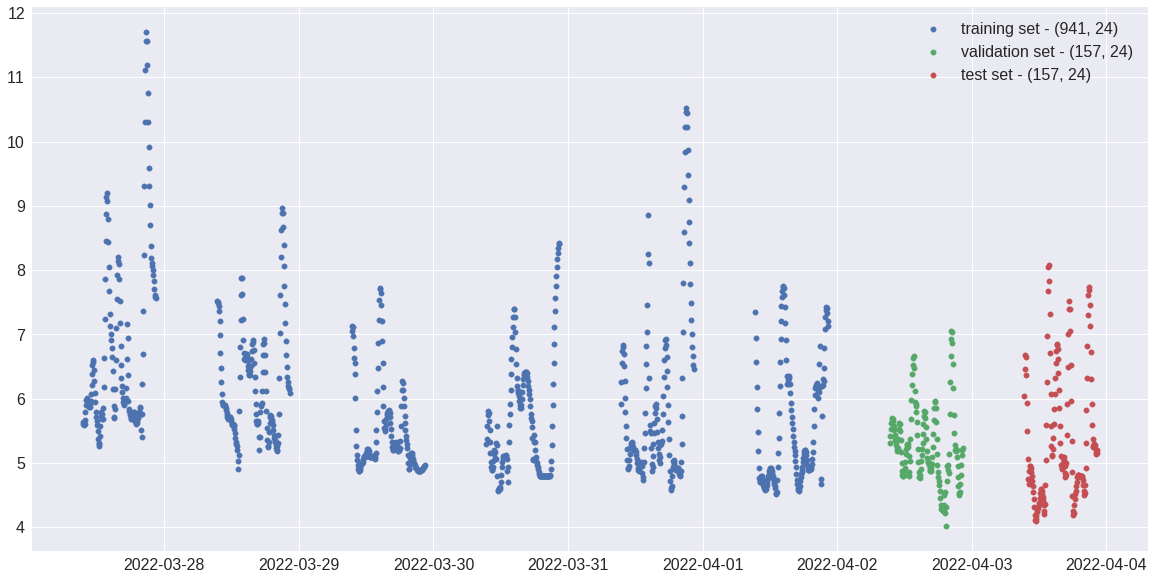

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(y=train['glucose'], x=train.index,
           label=f"training set - {train.shape}", s=30)
ax.scatter(y=val['glucose'], x=val.index,
           label=f"validation set - {val.shape}", s=30)
ax.scatter(y=test['glucose'], x=test.index,
           label=f"test set - {test.shape}", s=30)
ax.legend()

In [ ]:
X_train_scaled, X_val_scaled, X_test_scaled, y_train_scaled, y_val_scaled, \
y_test_scaled, scaler = scale_df(train, val, test, scaler=MinMaxScaler(), 
                                 drop_dependent=False, return_as_np=True)

Shape of train: (941, 24), shape of validation: (157, 24),  shape of test: (157, 24)


In [ ]:
# for testing purposes, None to use all values, e.g. 50 to use first 50 values only

UP_TO = None
X_train = X_train_scaled[:UP_TO]
X_val = X_val_scaled[:UP_TO]
X_test = X_test_scaled[:UP_TO]

y_train = y_train_scaled[:UP_TO]
y_val = y_val_scaled[:UP_TO]
y_test = y_test_scaled[:UP_TO]

- Data: Indexable generator (such as list or Numpy array)
    containing consecutive data points (timesteps).
    The data should be at 2D, and axis 0 is expected
    to be the time dimension.
- Targets: Targets corresponding to timesteps in `data`.
    It should have same length as `data`.
- Length: Length of the output sequences (in number of timesteps).

In [ ]:
# utility variable

FCAST_WINDOW = 24
PRED_WINDOW = 24

look_back = int(FCAST_WINDOW) # no. of timesteps to look back
batch_size = int(PRED_WINDOW) # no. of ts samples in each batch
seq_length = X_train.shape[0] # no. of output sequences (in no. of timesteps)
n_features = X_train.shape[1] # how many features

Useful S.O threads:
- Shaping data: https://stackoverflow.com/a/62876936
- Using Keras TimeseriesGenerator: https://stackoverflow.com/a/61642690

In [ ]:
# train data
train_data_gen = TimeseriesGenerator(data=X_train,
                                     targets=y_train,
                                     length=look_back,
                                     batch_size=batch_size)

# val data
val_data_gen = TimeseriesGenerator(data=X_val,
                                    targets=y_val,
                                    length=look_back,
                                    batch_size=batch_size)

# test data
test_data_gen = TimeseriesGenerator(data=X_test,
                                    targets=y_test,
                                    length=look_back,
                                    batch_size=batch_size)

# LSTM Shapes
- lstm 3D shape [samples, timesteps, features].
    - Samples. One sequence is one sample. A batch is comprised of one or more samples.
    - Time Steps. One time step is one point of observation in the sample. One sample is comprised of multiple time steps.
    - Features. One feature is one observation at a time step. One time step is comprised of one or more features.

In [ ]:
print(f'X_train shape is {X_train.shape}, X_validation shape is {X_val.shape}, X_test shape is {X_test.shape}')
print(f'y_train shape is {y_train.shape}, y_validation shape is {y_val.shape}, X_test shape is {y_test.shape}')

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

X_train shape is (941, 24), X_validation shape is (157, 24), X_test shape is (157, 24)
y_train shape is (941, 1), y_validation shape is (157, 1), X_test shape is (157, 1)
(941, 24)
(157, 24)
(157, 24)
(941, 1)
(157, 1)
(157, 1)


LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, n_features), return_sequences=True)) # 32 inputs into 256 neurons
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mse', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 256)           287744    
                                                                 
 dropout (Dropout)           (None, 24, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 813,313
Trainable params: 813,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# stop early if performance plateaus
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True)

In [ ]:
EPOCHS = 30

model.fit(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[early_stop]
    )

Epoch 1/30
39/39 [==============================] - 13s 55ms/step - loss: 0.0620 - val_loss: 0.0141
Epoch 2/30
39/39 [==============================] - 1s 14ms/step - loss: 0.0212 - val_loss: 0.0164
Epoch 3/30
39/39 [==============================] - 1s 18ms/step - loss: 0.0200 - val_loss: 0.0076
Epoch 4/30
39/39 [==============================] - 1s 20ms/step - loss: 0.0104 - val_loss: 0.0046
Epoch 5/30
39/39 [==============================] - 1s 15ms/step - loss: 0.0080 - val_loss: 0.0039
Epoch 6/30
39/39 [==============================] - 1s 18ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 7/30
39/39 [==============================] - 1s 14ms/step - loss: 0.0050 - val_loss: 0.0056
Epoch 8/30
39/39 [==============================] - 0s 12ms/step - loss: 0.0050 - val_loss: 0.0022
Epoch 9/30
39/39 [==============================] - 1s 16ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 10/30
39/39 [==============================] - 0s 9ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 11/

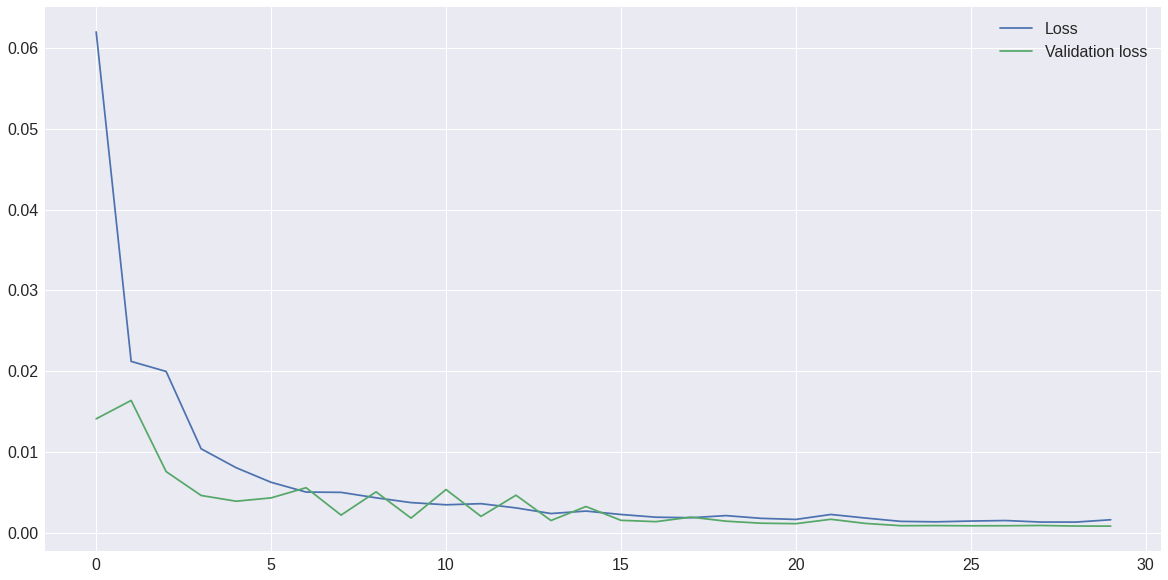

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(model.history.history['loss'], label='Loss')
ax.plot(model.history.history['val_loss'], label='Validation loss')
ax.legend()

Evaluate on test data (multi step prediction)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(941, 24)
(157, 24)
(941, 1)
(157, 1)


In [ ]:
loss = model.evaluate(test_data_gen)
print(f'Loss = {loss}')

6/6 [==============================] - 0s 4ms/step - loss: 9.3712e-04
Loss = 0.0009371188934892416


In [ ]:
test_predict = model.predict(test_data_gen)
tx_test_predict = scaler.inverse_transform(test_predict)

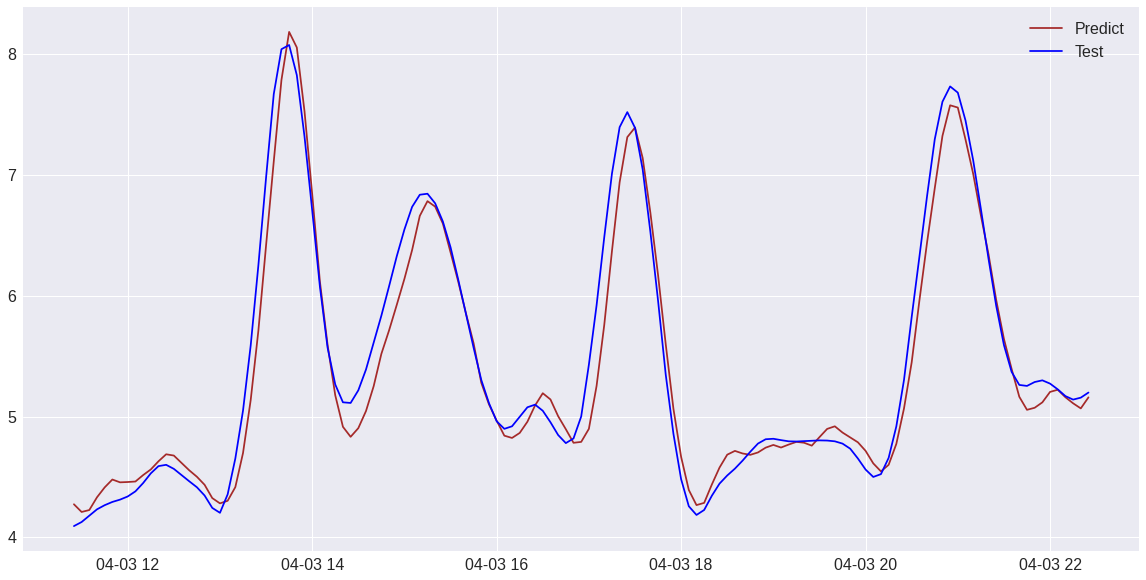

In [ ]:
truncated_test = test['glucose'].iloc[look_back:].values
idx = test.iloc[look_back:].index

def make_df_plotting(data_in_np, idx_to_use):
    graph = pd.DataFrame(
        data=data_in_np.reshape(-1, 1),
        index=idx_to_use
    )
    return graph

pred_plot = make_df_plotting(tx_test_predict, idx_to_use=idx)
test_plot = make_df_plotting(truncated_test, idx_to_use=idx)

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(pred_plot, color="brown", label='Predict')
ax.plot(test_plot, color="blue", label='Test')
ax.legend()

In [ ]:
ts_eval_metrics(y_true=truncated_test, y_pred=tx_test_predict)

{'mae': 0.15954295519317307,
 'mape': 19.785743934893585,
 'mse': 0.04849353148292465,
 'r2': 0.9559608733110034,
 'rmse': 0.22021246895424576}

Optional:
Plotting the results from all model experiments conducted

In [ ]:
naive = {}
naive['RMSE'] = 1.133150226452969
naive['MAE']= 1.043660464896398

arimax = {}
arimax['RMSE'] = 1.1787040912744422
arimax['MAE'] = 0.9927890326156574

varmax = {}
varmax['RMSE'] = 1.0421288070043684
varmax['MAE'] = 0.9128914303635964

lstm = {}
lstm['RMSE'] = 0.9874549185363565
lstm['MAE'] = 0.7850276197558462

lstm_dep = {}
lstm_dep['RMSE'] = 0.3054100960028255
lstm_dep['MAE'] = 0.25459272617416884

# all_err = [naive, arimax, varmax, lstm, lstm_dep]

all_err = pd.DataFrame([naive, arimax, varmax, lstm, lstm_dep],
                       index=['Naive Mean', 'ARIMAX', 'VARMAX', 'LSTM', 'LSTM w/ dependent'])

all_err.index.rename("Models", inplace=True)

In [ ]:
px.bar(all_err, barmode='group', orientation='h')